In [1]:
import numpy as np

# CNN
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils

# plot
from matplotlib import pyplot as plt
%matplotlib inline  
import os
from PIL import Image
import tensorflow as tf
import glob

np.random.seed(123)  # for reproducibility
captcha_num_chars = 6
num_chars = 36

# Abrir dataset

JW4CZF
<class 'numpy.ndarray'>


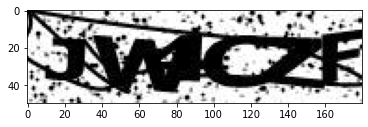

In [2]:
# Filelist dos dados
test_filelist = glob.glob('dados/teste/*.jpg')
valid_filelist = glob.glob('dados/validacao/*.jpg')
train_filelist = glob.glob('dados/treinamento/*.jpg')
labels_filelist = glob.glob('dados/labels10k/*.txt')

# Importar imagens
test  = np.array([np.array(Image.open(file).getchannel('R')) for file in test_filelist])
valid = np.array([np.array(Image.open(file).getchannel('R')) for file in valid_filelist])
train = np.array([np.array(Image.open(file).getchannel('R')) for file in train_filelist])

# Importar labels
all_labels = [open(file, "r").read(captcha_num_chars) for file in labels_filelist]
test_lbs  = all_labels[9000:10000]
valid_lbs = all_labels[8000:9000]
train_lbs = all_labels[:8000]

# Eliminar captchas com '?'
def removeInterrogation(ims, lbs):
    temp_lb = []
    temp_im = []

    for i in range(len(lbs)):
        s = list(lbs[i])
        if '?' not in s:
            temp_im.append(ims[i])
            temp_lb.append(lbs[i])
            
    return np.array(temp_im), temp_lb

test,  test_lbs  = removeInterrogation(test, test_lbs)
train, train_lbs = removeInterrogation(train, train_lbs)
valid, valid_lbs = removeInterrogation(valid, valid_lbs)

print(test_lbs[0])
print(type(test))
plt.imshow(test[0], cmap='gray')

## Cortar as imagens

In [3]:
def cropCaptchas(arr):
    arr_cpd = []
    for im in arr:
        captcha = im[:,6:]
        for i in range(6):
            arr_cpd.append(captcha[:,29*i:29*i+29])
    return np.array(arr_cpd)

def cropLabels(arr):
    arr_cpd = []
    for s in arr:
        s = list(s)
        for i in range(6):
            arr_cpd.append(s[i])
    return arr_cpd
    
test_cpd  = cropCaptchas(test)
train_cpd = cropCaptchas(train)
valid_cpd = cropCaptchas(valid)

test_lbs  = cropLabels(test_lbs)
train_lbs = cropLabels(train_lbs)
valid_lbs = cropLabels(valid_lbs)

## Preprocessamento dos dados de entrada para o Keras

In [4]:
height, width = 50, 29
# Reshape dos arrays
test_cpd  = test_cpd.reshape(test_cpd.shape[0], height, width, 1)
train = train_cpd.reshape(train_cpd.shape[0], height, width, 1)
valid = valid_cpd.reshape(valid_cpd.shape[0], height, width, 1)

print(valid.shape)

(6000, 50, 29, 1)


In [5]:
# Normalização dos valores dos pixels para [0,1]
test_cpd = test_cpd.astype('float32') 
test_cpd /= 255
valid = valid.astype('float32') 
valid /= 255
train = train.astype('float32')
train /= 255

## Preprocessamento dos labels das classes para o Keras

In [6]:
# transformar as letras em np array
chars = list('0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')
def toCategorical(arr):
    cat = []
    for c in arr:
        vec = np.zeros((36), dtype='float32')
        vec[chars.index(c)] = 1.
        cat.append(vec)
    return np.array(cat)

In [7]:
test_lbs_cat  = toCategorical(test_lbs)
valid_lbs_cat = toCategorical(valid_lbs)
train_lbs_cat = toCategorical(train_lbs)

print(test_cpd.shape)
print("class ID: ", test_lbs[2])
print("Network output: ", test_lbs_cat[2])

(6000, 50, 29, 1)
class ID:  4
Network output:  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


# Definir arquitetura do modelo

In [8]:
# Equivalente a model.predict()
def model(a):
    return [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]

# Treinamento do modelo

# Testes 

In [9]:
# transformar as np array em letras
def fromCategorical(arr):
    arr = list(arr)
    i = arr.index(1)
    return chars[i]


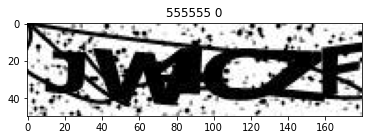

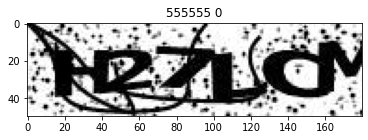

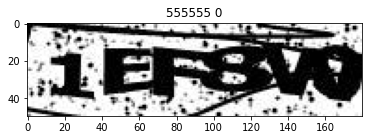

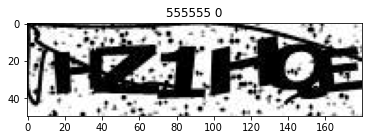

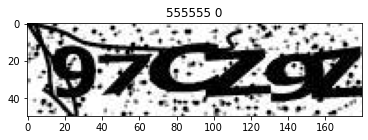

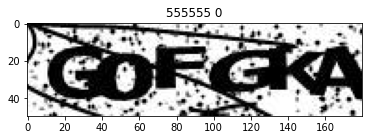

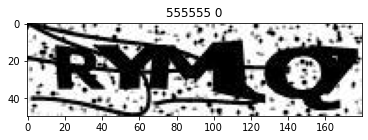

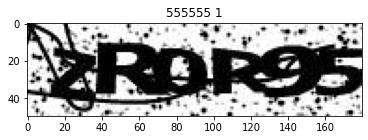

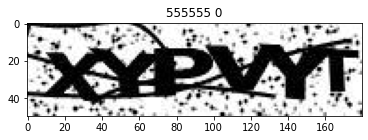

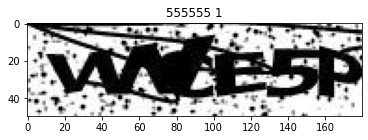

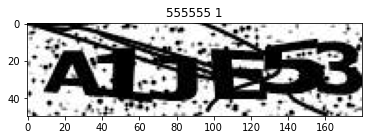

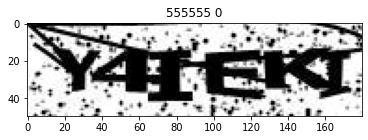

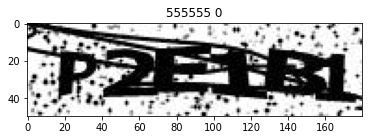

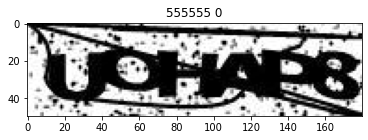

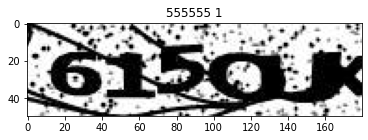

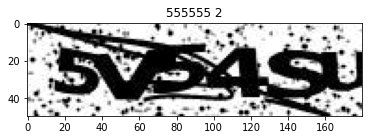

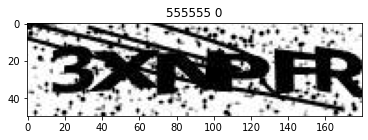

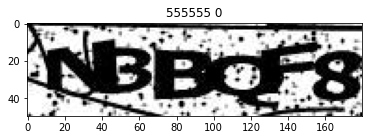

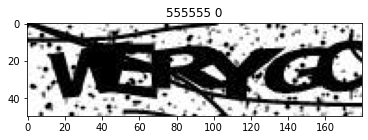

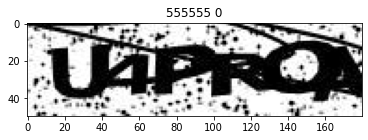

In [11]:
# Acertos por palavra
acertos = []

#predictions = model.predict(x= test_cpd, verbose = 1)

for i in range(20):
#for i in range(len(test)):
    acerto = 0
    resposta = ''
    for j in range(6):
        #c = fromCategorical(predictions[j+i*6])
        c = fromCategorical(model(test_cpd[j+i*6]))
        if c == test_lbs[j+i*6]:
            acerto+=1
        resposta += c
    acertos.append(acerto)
    
    plt.title(resposta +' '+ str(acerto))
    plt.imshow(test[i],cmap = "gray")
    plt.show()

In [12]:
print(acertos)

[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 2, 0, 0, 0, 0]


In [42]:
count = []
for i in range(7):
    count.append(acertos.count(i))

rate = []
for i in range(7):
    rate.append(float(sum(count[i:])))

rate = np.array(rate)
rate/= rate[0]
print(rate)

[1.   0.25 0.05 0.   0.   0.   0.  ]


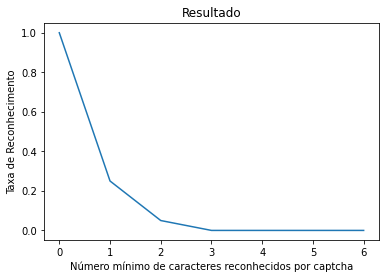

In [44]:
plt.title('Resultado')
plt.xlabel('Número mínimo de caracteres reconhecidos por captcha')
plt.ylabel('Taxa de Reconhecimento')
plt.plot(list(range(7)), rate)
plt.show()